Nano Yagi-Uda: Directional Plasmonic Antenna
=================================

*Author: Clément Majorel (asymptotic field propagator inside substrate by C. Majorel)*


In this example, we reproduce the results of [1], where a plasmonic directional antenna  with the design of a nano-Yagi-Uda is demonstrated.

[1] A. G. Curto, G. Volpe, T. H. Taminiau, M. P. Kreuzer, R. Quidant, and N. F. van Hulst, *Unidirectional Emission of a Quantum Dot Coupled to a Nanoantenna*, Science 329(5994), 930–933, (2010) (http://dx.doi.org/10.1126/science.1191922)

In [1]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import linear
from pyGDM2 import tools
from pyGDM2 import visu

import numpy as np
import copy
import matplotlib.pyplot as plt

Simulation setup
----------------------

Again, we setup the simulation. This time we will use an *electric dipolar emitter* as light source, which is an appropriate description for a quantum dot emitter.
The dipole will be placed at the edge of the driving element of the nano Yagi-Uda. Since the dipoles oriented along the gold-rod will couple most efficiently, we restrict this example to that dipole orientation. In order to simulate the realistic case of a random mix of orientations, the simulation needs to be run for each orientation and an in-coherent sum of the farfield intensities needs to be done. 

In [2]:
## --- structure and envorinment
step = 10.
mesh = 'cube'

## --- We now construct the Yagi-Uda antenna made of several gold-rods
## (dimensions of the rods in nm)
R_nm = 30.          # radius
L_dir = 115.        # length of director rods
L_feed = 145.       # length of feed rod
L_ref = 170.        # length of reflector rod

## -- matrix rotation around the z axis to turn all the rod long axis along the Y orientation
Rz = np.array([[0.,-1.,0.],[1.,0.,0.],[0.,0.,1.]])

## --- director rods
## --- first director rod centered in (0,0) in the XY plane and rotated
geo1 = structures.nanorod(step, L=int(L_dir/step), R=int(R_nm/step), caps='flat')
geo1 = np.dot(geo1, Rz)
## --- second director rod translate at the position (150, 0) in the XY plane
geo2 = copy.deepcopy(geo1)
geo2.T[0]+=150
## --- third director rod translate at the position (300, 0) in the XY plane
geo3 = copy.deepcopy(geo1)
geo3.T[0]+=300
### --- feed rod
### --- translate at the position (-170, 0) in the XY plane and rotated
geo4 = structures.nanorod(step, L=int(L_feed/step), R=int(R_nm/step), caps='flat')
geo4 = np.dot(geo4, Rz)
geo4.T[0]-=170
### --- reflector rod
### -- translate at the position (-370, 0) in the XY plane and rotated
geo5 = structures.nanorod(step, L=int(L_ref/step), R=int(R_nm/step), caps='flat')
geo5 = np.dot(geo5, Rz)
geo5.T[0]-=370

### --- concatenation of all the structure lists in a single 
geometry = np.concatenate((geo1, geo2, geo3, geo4, geo5))
material = materials.gold()

struct = structures.struct(step, geometry, material)


## --- environment (glass sustrate, vacuum above)
n1, n2 = 1.5, 1.0
dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)


## --- incident field: dipolar emitter
## --- dipole position at the extremity of the long axis of the feed rod 
x0 = np.mean(geo4.T[0])
y0 = np.max(geo4.T[1])+step
z0 = np.mean(geo4.T[2])

## --- dipole orientation
p=np.array([0.,1.,0.])

## --- Setup incident field
field_generator = fields.dipole_electric   # light-source: dipolar emitter
kwargs = dict(x0=x0, y0=y0, z0=z0, 
              mx=p[0], my=p[1], mz=p[2])
wavelengths = [820.]
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## --- Simulation object
sim = core.simulation(struct, efield, dyads)

## --- print a summary
tools.print_sim_info(sim, verbose=1)

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 2405/2405 dipoles valid

 =============== GDM Simulation Information ===============
precision: <class 'numpy.float32'> / <class 'numpy.complex64'>


 ------ nano-object -------
   Homogeneous object. 
   material:             "Gold, Johnson/Christy"
   mesh type:            cubic
   nominal stepsize:     10.0nm
   nr. of meshpoints:    2405

 ----- incident field -----
   field generator: "dipole_electric"
   1 wavelengths between 820.0 and 820.0nm
      - 0: 820.0nm
   1 incident field configurations per wavelength
      - 0: 'mx': 0.0, 'my': 1.0, 'mz': 0.0, 'x0': -170.0, 'y0': 80.0, 'z0': 35.0

 ------ environment -------
   n3 = constant index material, n=(1+0j)  <-- top
   n2 = constant index material, n=(1+0j)  <-- center layer (height "spacing" = 5000nm)
   n1 = constant index material, n=(1.5+0j)  <-- substrate

 ===== *core.scatter* ======
   NO self-consistent E-fields
   N

Run the simulation
---------------------------------------

After the main simulation (*scatter*), we will calculate the spatial distribution of the farfield intensity in the lower hemisphere (--> into substrate) using *linear.farfield*.

In [3]:
sim.scatter()

## --- farfield pattern ("backfocal plane image")
## 2D
Nteta=200
Nphi=4
teta_above, phi_above, I_sc_above, I_tot_above, I0_above = linear.farfield(
                                sim, field_index=0,
                                tetamin=0, tetamax=np.pi, 
                                Nteta=Nteta, Nphi=Nphi)
## 3D
Nteta=40
Nphi=2*72
teta_below, phi_below, I_sc_below, I_tot_below, I0_below = linear.farfield(
                                sim, field_index=0,
                                tetamin=np.pi/2., tetamax=np.pi, 
                                Nteta=Nteta, Nphi=Nphi)

timing for wl=820.00nm - setup: EE 3574.8ms, inv.: 4434.2ms, repropa.: 553.8ms (1 field configs), tot: 8563.2ms


Plot the farfield intensity distribution
---------------------------------------------

/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


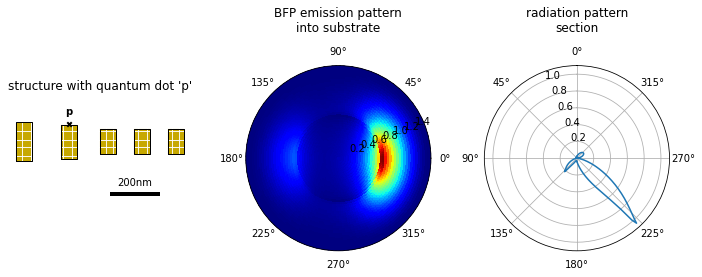

In [4]:
scale_I = 1/I_sc_below.max()

def conf_polar():
    plt.ylim([0, 90])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])


plt.figure(figsize=(10,4))

## --- structure geometry
plt.subplot(131, aspect='equal')
plt.title("structure with quantum dot 'p'", y =1.3)
plt.axis('off')

## structure
visu.structure(sim, color='#c7a800', scale=1, show=False)
visu.structure_contour(sim, color='k', show=False)

## dipole position
plt.text(sim.efield.kwargs['x0'][0], sim.efield.kwargs['y0'][0]+20, 
                                     r"$\mathbf{p}$", ha='center', va='bottom')
plt.scatter([sim.efield.kwargs['x0']], [sim.efield.kwargs['y0']], 
                                    marker='x', linewidth=2, s=20, color='k')

## scale bar
plt.text(120,-200, "200nm", ha='center', va='bottom')
plt.plot([20,220] , [-230,-230], lw=4, color='k', clip_on=False)


## --- 2D pattern into substrate
plt.subplot(132, polar=True)
plt.title("BFP emission pattern\ninto substrate", x=0.5, y=1.15)
im = visu.farfield_pattern_2D(np.pi-teta_below, phi_below, I_tot_below*scale_I, 
                              cmap='jet', degrees=False, show=False)

## --- pattern section
plt.subplot(133, polar=True)
plt.title("radiation pattern\nsection", x=0.5, y=1.15)
plt.gca().set_theta_zero_location("N")
plt.plot(-1*teta_above.T[0], I_tot_above.T[0]*scale_I, color='C0')
plt.plot(-1*(2*np.pi - teta_above.T[2]), I_tot_above.T[2]*scale_I, color='C0')     


plt.tight_layout()
plt.show()
